In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import pickle
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix


[nltk_data] Downloading package punkt to C:\Users\Kevin
[nltk_data]     Patel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Kevin
[nltk_data]     Patel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

##### ==> When reading the dataset UTF-8 encoding is not supported.

##### So we find the encoding supported and use that to read the CSV.

In [4]:
# Use chardet to find out the encoding type
import chardet 

with open('datasets/spam.csv', 'rb') as f:
    raw_data = f.read(10000) #First 10 kb should be enough
    result = chardet.detect(raw_data)
    detected_encoding = result['encoding']

# Use the detected encoding to read the CSV file
df = pd.read_csv('datasets/spam.csv', encoding=detected_encoding)

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
df.shape #More than 5k messages

(5572, 5)

# 1.Data Cleaning

In [7]:
df.info() #No null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [8]:
#Drop last three columns
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
# Renaming columns
df.columns = ['label', 'text']
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
#Encoding labels
encoder = LabelEncoder()

# 0 for not spam and 1 for spam

df['label'] = encoder.fit_transform(df['label'])
df.head(5)

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
# Check for missing values

df.isnull().sum() # No missing values

label    0
text     0
dtype: int64

In [12]:
# Check for duplicates 
df.duplicated().sum()
# 403 duplicated messages


#Drop duplicates
df = df.drop_duplicates(keep= 'first')

# Again check for duplicates
df.duplicated().sum()

0

In [13]:
df.shape

(5169, 2)

# 2.EDA 

In [14]:
df['label'].value_counts()

label
0    4516
1     653
Name: count, dtype: int64

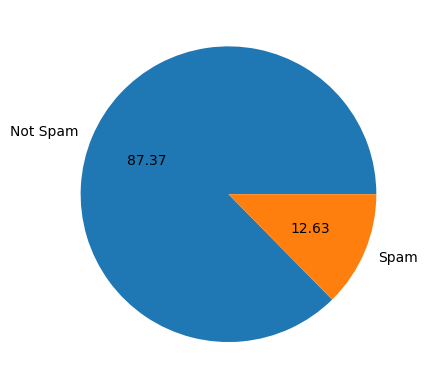

In [15]:
# Create a pie plot
plt.pie(df['label'].value_counts(), labels=['Not Spam', 'Spam'],autopct='%0.2f'
)
plt.show()

##### We are given an imbalance dataset (90:10) ratio approx.

In [16]:
df['num_char'] = df['text'].apply(len) # Find the characters in sms

In [17]:
df['words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x))) # Find the words in sms

In [18]:
df['Sentence'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x))) # Find the sentences in sms

In [19]:
df[['num_char', 'words', 'Sentence']].describe()

,num_char,words,Sentence
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [20]:
# For ham messages
df[df['label'] == 0][['num_char', 'words', 'Sentence']].describe()

# On an average a ham message is 78 characters long, 17 words and 2 sentences

,num_char,words,Sentence
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [21]:
# For spam messages
df[df['label'] == 1][['num_char', 'words', 'Sentence']].describe()

# On an average a spam message is 138 characters long, 27 words and 3 sentences

,num_char,words,Sentence
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


<Axes: xlabel='num_char', ylabel='Count'>

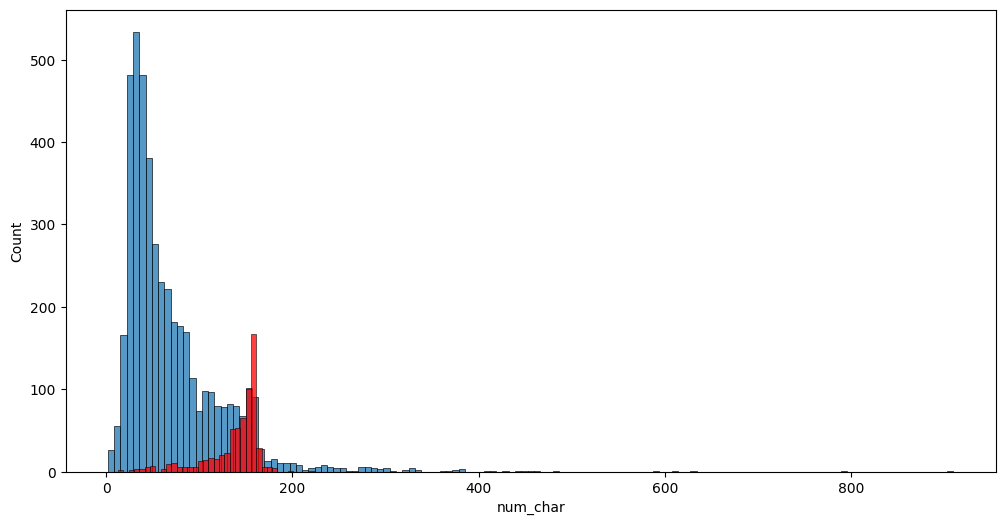

In [22]:
# Plot a histogram for characters of ham and spam messages
plt.figure(figsize=(12,6))
sns.histplot(df[df['label'] == 0]['num_char'], label = 'Ham')
sns.histplot(df[df['label'] == 1]['num_char'], label = 'Spam',color='red')

# Spam messages have more characters than ham messages


<Axes: xlabel='words', ylabel='Count'>

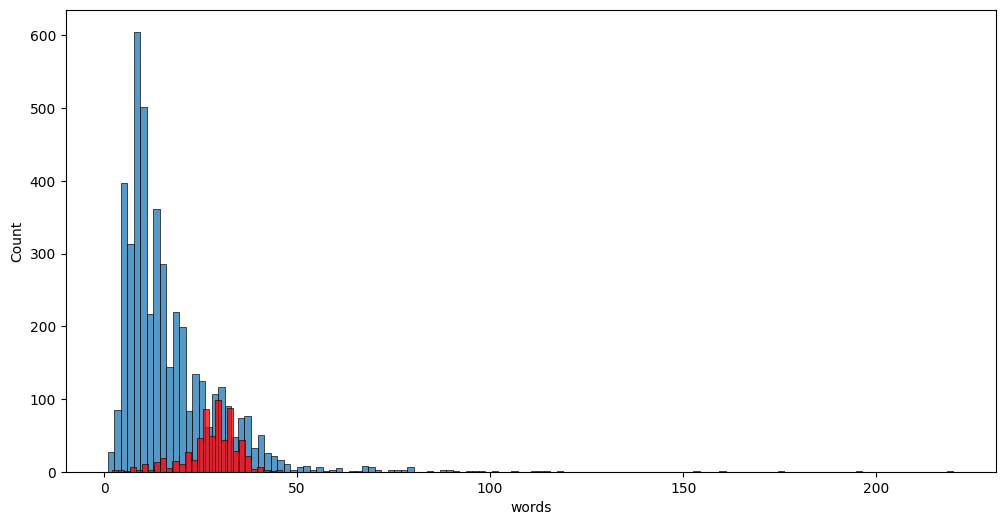

In [23]:
# Plot a histogram for words of ham and spam messages
plt.figure(figsize=(12,6))
sns.histplot(df[df['label'] == 0]['words'], label = 'Ham')
sns.histplot(df[df['label'] == 1]['words'], label = 'Spam',color='red')

# Spam messages have more words than ham messages

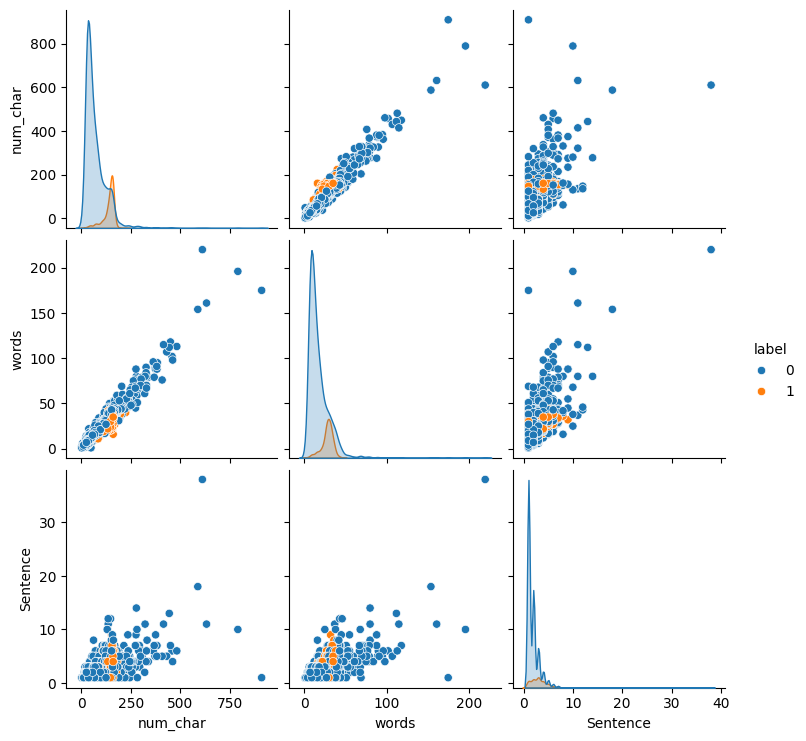

In [24]:
sns.pairplot(df, hue = 'label')

# There are many outliers in the dataset

<Axes: >

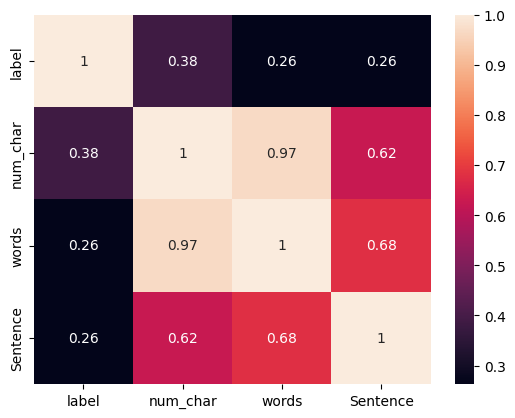

In [25]:
df_numeric = df.select_dtypes(include=['number'])

sns.heatmap(df_numeric.corr(),annot=True)

# There is a strong correlation between num_char and words, and between words and sentences
# There is a weak correlation between num_char and sentences


# 3.Data Preprocessing
##### • Lower Case
##### • Tokenization
##### • Removing special characters
##### • Removing stop words and punctuations
##### • Stemming( converting walk, walking, walked into walk)

In [26]:
def transform_text(text):
    text = text.lower() # Lowercase the text
    text = nltk.word_tokenize(text) # Tokenize the text
    y = [] # Create an empty list to store the alphanumeric characters
    for i in text:
        if i.isalnum():
            y.append(i) # Append the alphanumeric characters to the list
    text = y[:] # Create a copy of the list
    y.clear() # Clear the list
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    text = y[:]
    y.clear() 
    ps = PorterStemmer() # Create a PorterStemmer object
    for i in text:
        y.append(ps.stem(i))
    return ' '.join(y) # Join the list of words into a string and return it
    
    

In [27]:
df['transformed_text'] = df['text'].apply(transform_text) # Apply the transform_text function to the text column

In [28]:
df.head(5) # Check the transformed text

,label,text,num_char,words,Sentence,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [29]:
wc = WordCloud(width = 500, height = 500,min_font_size=10, background_color='white')

spam_wc = wc.generate(df[df['label']==1]['transformed_text'].str.cat(sep=' ')) # Generate a word cloud for spam messages
ham_wc = wc.generate(df[df['label']==0]['transformed_text'].str.cat(sep=' ')) # Generate a word cloud for ham messages

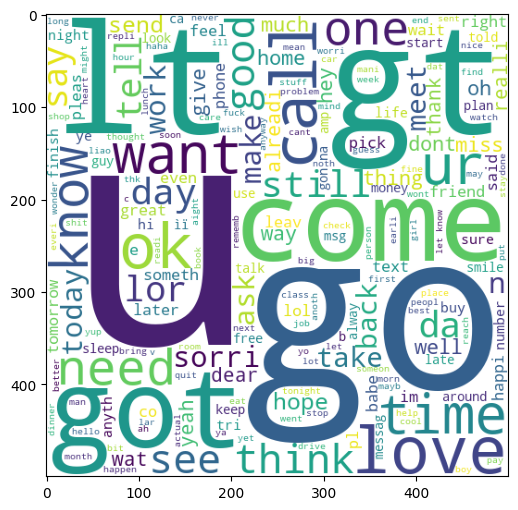

In [30]:
plt.figure(figsize=(12,6))
plt.imshow(spam_wc) # Show the word cloud for spam messages

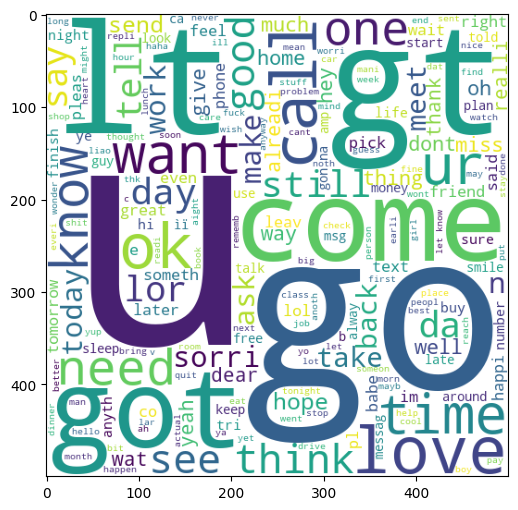

In [31]:
plt.figure(figsize=(12,6))
plt.imshow(ham_wc) # Show the word cloud for ham messages

In [32]:
# Now we will find the most common words in spam and ham messages
spam_corpus = []
ham_corpus = []
for msg in df[df['label'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word) # Append the words to the spam_corpus list
for msg in df[df['label'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word) # Append the words to the ham_corpus list
len(spam_corpus) # Number of words in spam messages

9939

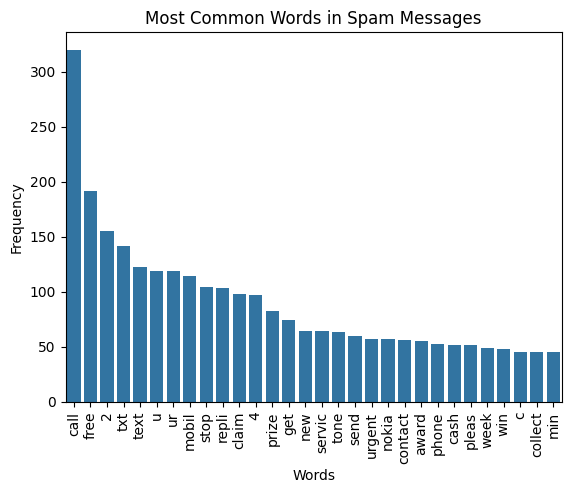

In [33]:
# Fix the barplot by specifying x and y as keyword arguments
most_common_spam = pd.DataFrame(Counter(spam_corpus).most_common(30))
sns.barplot(x=most_common_spam[0], y=most_common_spam[1])
plt.xticks(rotation='vertical')
plt.title('Most Common Words in Spam Messages')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

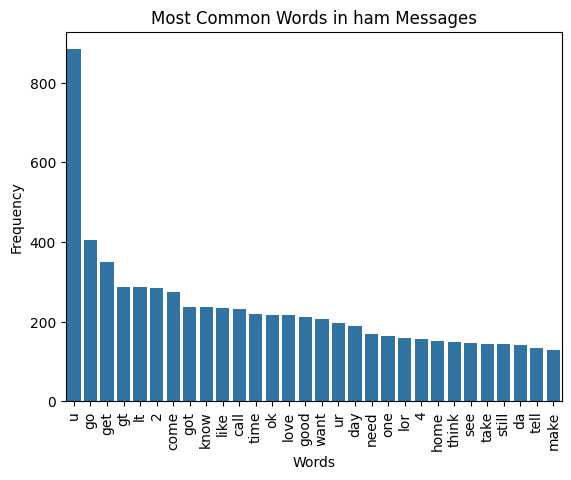

In [34]:
most_common_ham = pd.DataFrame(Counter(ham_corpus).most_common(30))
sns.barplot(x=most_common_ham[0], y=most_common_ham[1])
plt.xticks(rotation='vertical')
plt.title('Most Common Words in ham Messages')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

# 4.Model Building

In [35]:
# Naive Bayes Classifier(best for text classification)
# Vectorize the text data using bag of words
cv = CountVectorizer()

X = cv.fit_transform(df['transformed_text']).toarray() # Convert the text data into a matrix of token counts
y = df['label'].values # Get the labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Split the data into training and testing sets

#Models
mnb = MultinomialNB() # Create a Multinomial Naive Bayes classifier
bnb = BernoulliNB() # Create a Bernoulli Naive Bayes classifier
gnb = GaussianNB() # Create a Gaussian Naive Bayes classifier

In [36]:
# Gaussian Naive Bayes
gnb.fit(X_train, y_train) 
y_pred2 = gnb.predict(X_test) 
print('Accuracy score:',accuracy_score(y_test, y_pred2))
print('Precision score:',precision_score(y_test, y_pred2)) 
print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred2)) 

Accuracy score: 0.8684719535783365
Precision score: 0.5185185185185185
Confusion Matrix:
 [[772 117]
 [ 19 126]]


In [37]:
#Bernoulli Naive Bayes
bnb.fit(X_train, y_train) 
y_pred3 = bnb.predict(X_test) 
print('Accuracy score:',accuracy_score(y_test, y_pred3))
print('Precision score:',precision_score(y_test, y_pred3)) 
print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred3))

Accuracy score: 0.9661508704061895
Precision score: 0.9661016949152542
Confusion Matrix:
 [[885   4]
 [ 31 114]]


In [38]:
# Using TF-IDF Vectorizer
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['transformed_text']).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
mnb.fit(X_train, y_train)
y_pred1 = mnb.predict(X_test)
print('Accuracy score:',accuracy_score(y_test, y_pred1))
print('Precision score:',precision_score(y_test, y_pred1))
print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred1))


# Precision score is better with TF-IDF Vectorizer than Count Vectorizer
# So we will use TF-IDF Vectorizer for our final model

Accuracy score: 0.9613152804642167
Precision score: 0.9906542056074766
Confusion Matrix:
 [[888   1]
 [ 39 106]]


In [39]:
# Using different classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'SVC': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Bagging': BaggingClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(),
    'multinomialNB': MultinomialNB()
}
results = {} 
for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    results[name] = {'Accuracy': accuracy, 'Precision': precision}

c:\Users\Kevin Patel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [40]:
# Print the results
results_df = pd.DataFrame(results).T
results_df.sort_values(by='Precision', ascending=False, inplace=True)
print(results_df)



                     Accuracy  Precision
KNN                  0.896518   1.000000
Extra Trees          0.973888   0.991667
Random Forest        0.969052   0.991304
SVC                  0.968085   0.991228
multinomialNB        0.961315   0.990654
Gradient Boosting    0.963250   0.965217
XGBoost              0.973888   0.953846
Logistic Regression  0.948743   0.942308
Bagging              0.960348   0.876812
AdaBoost             0.947776   0.842105
Decision Tree        0.951644   0.818792


In [47]:
et = ExtraTreesClassifier() # Create an Extra Trees classifier
et.fit(X_train, y_train) # Fit the model to the training data
y_pred = et.predict(X_test) # Predict the labels for the test data

In [48]:
pickle.dump(tfidf, open('vectorizer.pkl', 'wb')) # Save the TF-IDF vectorizer
pickle.dump(et, open('model.pkl', 'wb')) # Save the model